## Import modules

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import datetime
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import  matplotlib.dates as mdates
from tqdm import tqdm

sys.path.insert(0, '/mnt/afml/ml_finance/mlfinlab')
import mlfinlab as ml
from mlfinlab.data_structures import imbalance_data_structures as imbar, run_data_structures as rbar, standard_data_structures as bar

sys.path.insert(0, '/mnt/afml/ml_finance/finance_ml')
from finance_ml.multiprocessing import mp_pandas_obj
from finance_ml.sampling import bootstrap

## Plot

In [2]:
def plot_bars(df, df_bar, desc='bar'):
    plt.figure(figsize = (18, 8))
    plt.title('Bars over the prices')
    plt.plot(df.index, df['PRICE'], label = 'Raw prices', color = 'blue')
    plt.plot(df_bar.index, df_bar['close'], ls = '', markersize = 5, marker = 'o', color = 'red', label = desc)
    plt.legend()
    plt.show()

In [3]:
def plot_co_events(d0, df, t_barrier_events, num_co_events, avg_uniq): 
    df0 = df.loc[d0]
    t_barrier_events0 = t_barrier_events.loc[d0]
    num_co_events0 = num_co_events.loc[d0]
    avg_uniq0 = avg_uniq.loc[d0]
    
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111)

    plt.title('Triple barriers over the prices')
    plt.plot(df0.index.values, df0.close.values, label='raw_prices', ls='--', color='black')

    # Draw barrier region 
    for i in t_barrier_events0.itertuples(): 
        try: 
            t0, t1, trgt = i.Index, i.t1, i.trgt
            t1 = min(t1, pd.Timestamp("{} 15:30".format(d0)))

            x0 = mdates.date2num(t0)
            x1 = mdates.date2num(t1)
            w = x1 - x0 

            y0 = df0.loc[t0].close * (1 - trgt)
            y1 = df0.loc[t0].close * (1 + trgt)
            h = y1 - y0

            rect = Rectangle((x0, y0), w, h, color='black', alpha=0.05)
            ax.add_patch(rect)

            df1 = df0.loc[[t0, t1]].dropna()

            plt.plot(df1.index.values, df1.close.values, label='triple barrier', ls='--', color='red')
            if df1.shape[0] >= 2:
                plt.scatter(df1.index.values[1], df1.close.values[1], marker='o', linewidths=5, color='red')
                
        except Exception as e:
            print(e)
    plt.show()
    
    # Draw num of co-events
    num_co_events0.plot(kind='bar', figsize=(30,10), label='DV')
    plt.show()
    
    # Draw average uniqueness
    avg_uniq0.plot(kind='bar', figsize=(30,10), label='AvgUniqueness')
    plt.show()

## Load data

In [4]:
def load_parq(fname):
    table = pq.read_table(fname)
    df = table.to_pandas()
    df = df.set_index('TIMESTAMP')
    ''' 중복된 index 제거, volume은 더해준다 '''
    df = df.sort_values(by='TIMESTAMP')  # 중복 데이터 무시
    df_v = df.groupby(df.index).sum()
    df = df.loc[~df.index.duplicated(keep='first')]
    df['V'] = df_v['V']
    df['DV'] = df_v['DV']
    return df

In [5]:
fname = 'dataset/TRADE_A233740_2018.parq'
df = load_parq(fname)
df['close'] = df['PRICE']

In [6]:
fname = 'dataset/TRADE_A233740_2018.csv'
if not os.path.exists(fname):
    df_csv = df.reset_index()[['TIMESTAMP', 'PRICE', 'V']]
    df_csv.columns = ['date_time', 'price', 'volume']
    df_csv['price'] = df_csv['price'].astype('float')
    df_csv.to_csv(fname, index=False)
vbar = bar.get_volume_bars(fname, threshold=1e4)
vbar.index = pd.to_datetime(vbar.index)
fname = 'dataset/VBAR_A233740_2018.csv'
vbar.to_csv(fname)

Reading data in batches:
Batch number: 0
Returning bars 



## Triple barrier

In [7]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=vbar['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(vbar['close'], threshold=daily_vol.mean()*0.3)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=vbar['close'], num_days=1)

In [8]:
print(vbar.shape)
print(cusum_events.shape)
print(vertical_barriers.shape)

(331841, 5)
(86530,)
(86210,)


## Build Label

In [9]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=vbar['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers)

/mnt/afml/ml_finance/mlfinlab/mlfinlab/labeling/labeling.py:117: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-05-29 12:00:31.551465 100.0% apply_pt_sl_on_t1 done after 0.65 minutes. Remaining 0.0 minutes.


In [10]:
print(triple_barrier_events.shape)

(19118, 2)


In [11]:
vertical_barriers.loc[vertical_barriers.index>datetime.datetime(2018,5,24,9,0)].head()

2018-05-24 09:00:01.031   2018-05-25 09:00:14.483
2018-05-24 09:00:06.354   2018-05-25 09:00:14.483
2018-05-24 09:00:44.746   2018-05-25 09:00:56.925
2018-05-24 09:00:52.812   2018-05-25 09:00:56.925
2018-05-24 09:01:05.020   2018-05-25 09:01:14.931
Name: date_time, dtype: datetime64[ns]

In [12]:
triple_barrier_events.loc[triple_barrier_events.index>datetime.datetime(2018,5,23,9,0)].head()

,t1,trgt
2018-05-24 09:27:03.716,2018-05-24 09:42:52.085,0.005060
2018-05-24 09:27:44.483,2018-05-24 11:01:44.613,0.005773
2018-05-24 09:28:20.956,2018-05-24 09:42:52.085,0.005890
2018-05-24 09:29:22.306,2018-05-24 09:42:52.085,0.005898
2018-05-24 09:30:03.968,2018-05-24 11:03:14.446,0.005887


## Concurrency and Uniqueness

In [13]:
def get_num_co_events(close_idx, t1, molecule):
    # Find events that span the period defined by molecule
    t1 = t1.fillna(close_idx[-1])
    t1 = t1[t1 >= molecule[0]]
    t1 = t1.loc[:t1[molecule].max()]
    # Count the events
    iloc = close_idx.searchsorted(np.array([t1.index[0], t1.max()]))
    count = pd.Series(0, index=close_idx[iloc[0]: iloc[1] + 1])
    for t_in, t_out in t1.iteritems():
        count.loc[t_in: t_out] += 1
    return count.loc[molecule[0]: t1[molecule].max()]

In [14]:
num_threads = 3
num_co_events = mp_pandas_obj(get_num_co_events,
                              ('molecule', triple_barrier_events.index),
                              num_threads,
                              close_idx=vbar.index,
                              t1=triple_barrier_events['t1'])

# num_co_events = num_co_events.loc[~num_co_events.index.duplicated(keep='last')]
# num_co_events = num_co_events.reindex(close.index).fillna(0)

2019-05-29 12:00:46.132880 100.0% get_num_co_events done after 0.24 minutes. Remaining 0.0 minutes.


## Get avg uniqueness

In [15]:
def get_time_decay(tw, last_w=1., truncate=0, is_exp=False):
    cum_w = tw.sort_index().cumsum()
    init_w = 1.
    if is_exp:
        init_w = np.log(init_w)
    if last_w >= 0:
        if is_exp:
            last_w = np.log(last_w)
        slope = (init_w - last_w) / cum_w.iloc[-1]
    else:
        slope = init_w / ((last_w + 1) * cum_w.iloc[-1])
    const = init_w - slope * cum_w.iloc[-1]
    weights = const + slope * cum_w
    if is_exp:
        weights =np.exp(weights)
    weights[weights < truncate] = 0
    return weights

def get_sample_tw(t1, num_co_events, molecule):
    wght = pd.Series(index=molecule)
    for t_in, t_out in t1.loc[wght.index].iteritems():
        wght.loc[t_in] = (1. / num_co_events.loc[t_in: t_out]).mean()
    return wght

In [16]:
num_co_events = num_co_events.loc[~num_co_events.index.duplicated(keep='last')]
num_co_events = num_co_events.reindex(vbar.index).fillna(0)
tw = mp_pandas_obj(get_sample_tw,
                   ('molecule', triple_barrier_events.index),
                   num_threads,
                   t1=triple_barrier_events['t1'],
                   num_co_events=num_co_events)

2019-05-29 12:00:58.837909 100.0% get_sample_tw done after 0.18 minutes. Remaining 0.0 minutes.


/mnt/afml/venv/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


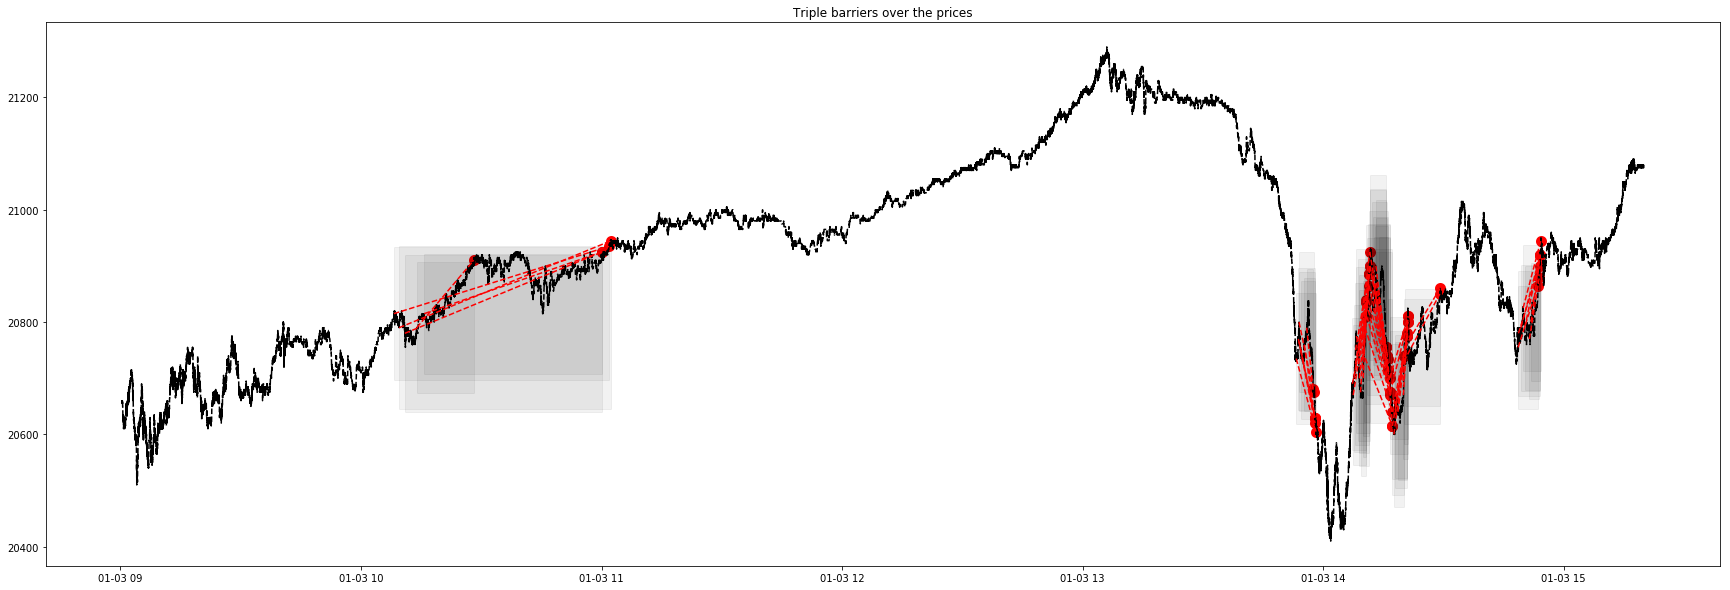

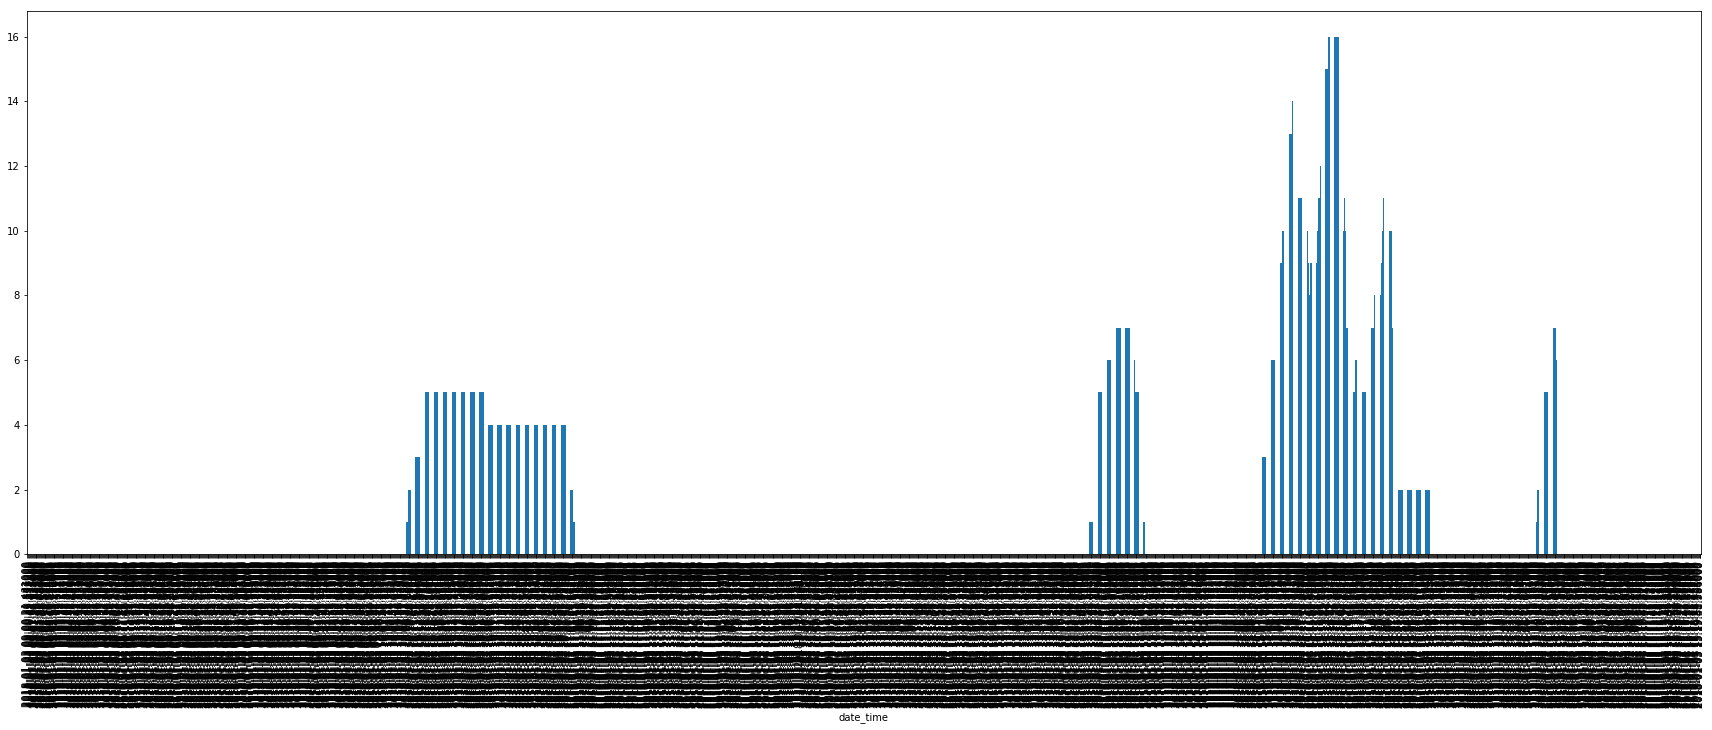

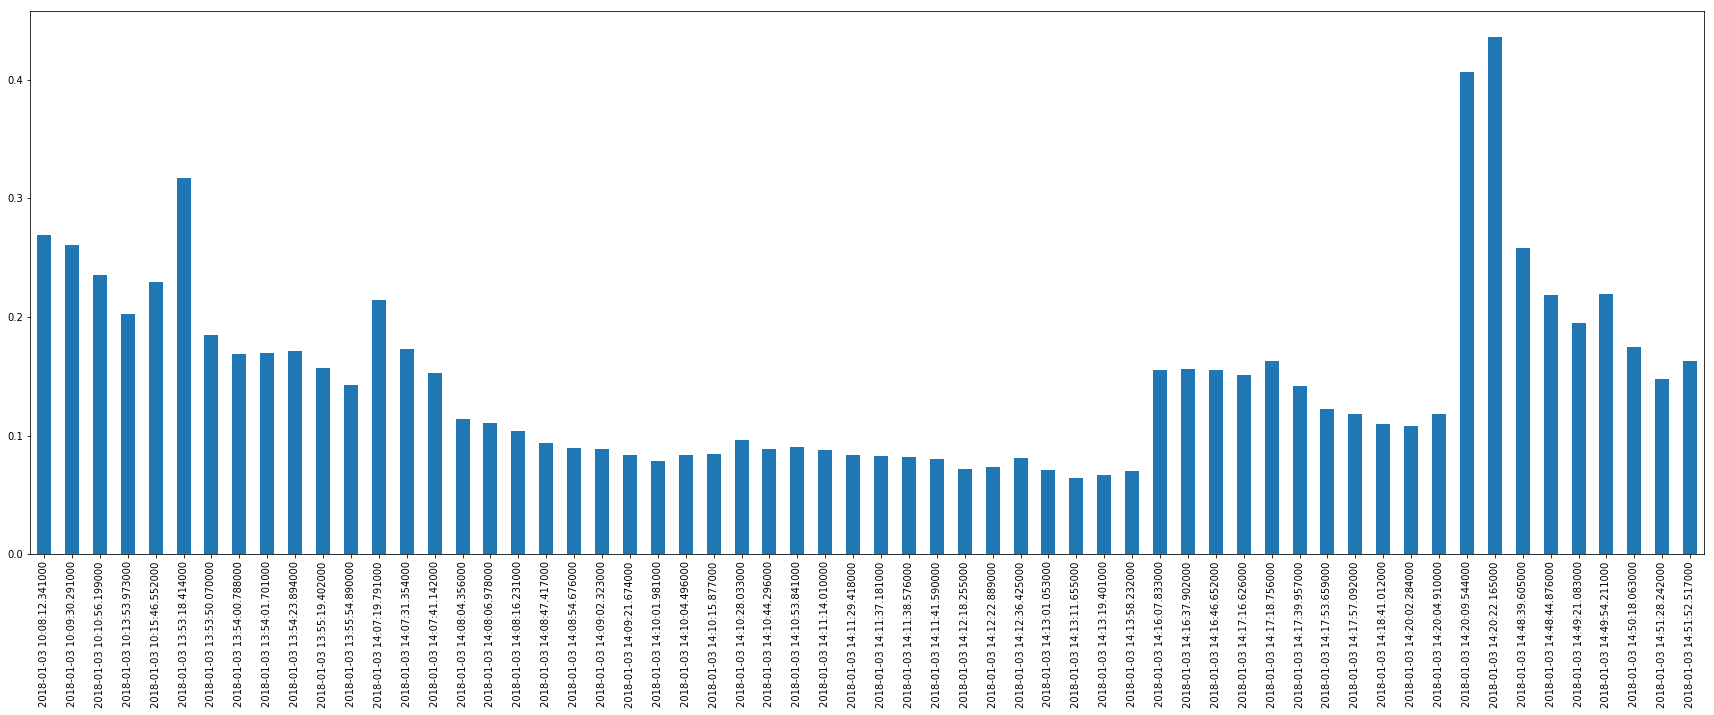

In [17]:
plot_co_events('2018-01-03', df, triple_barrier_events, num_co_events, tw)

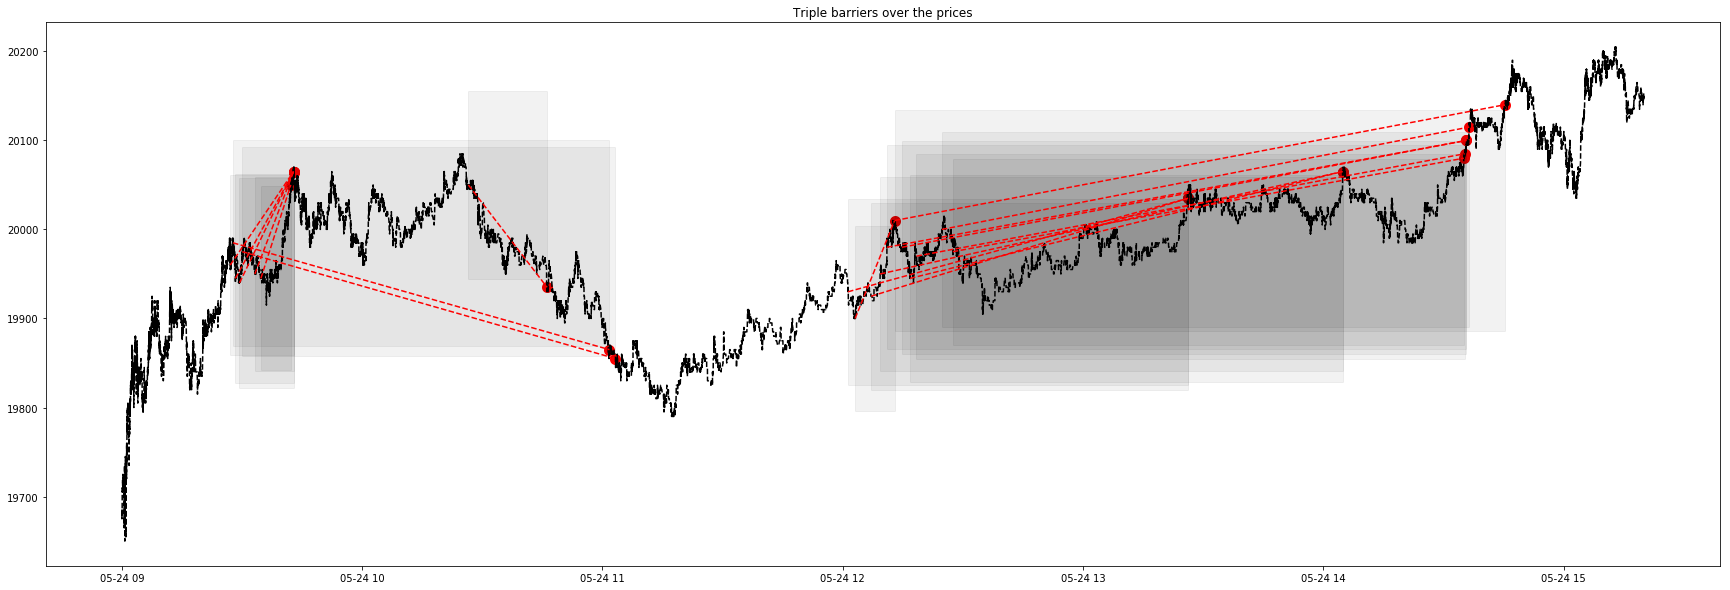

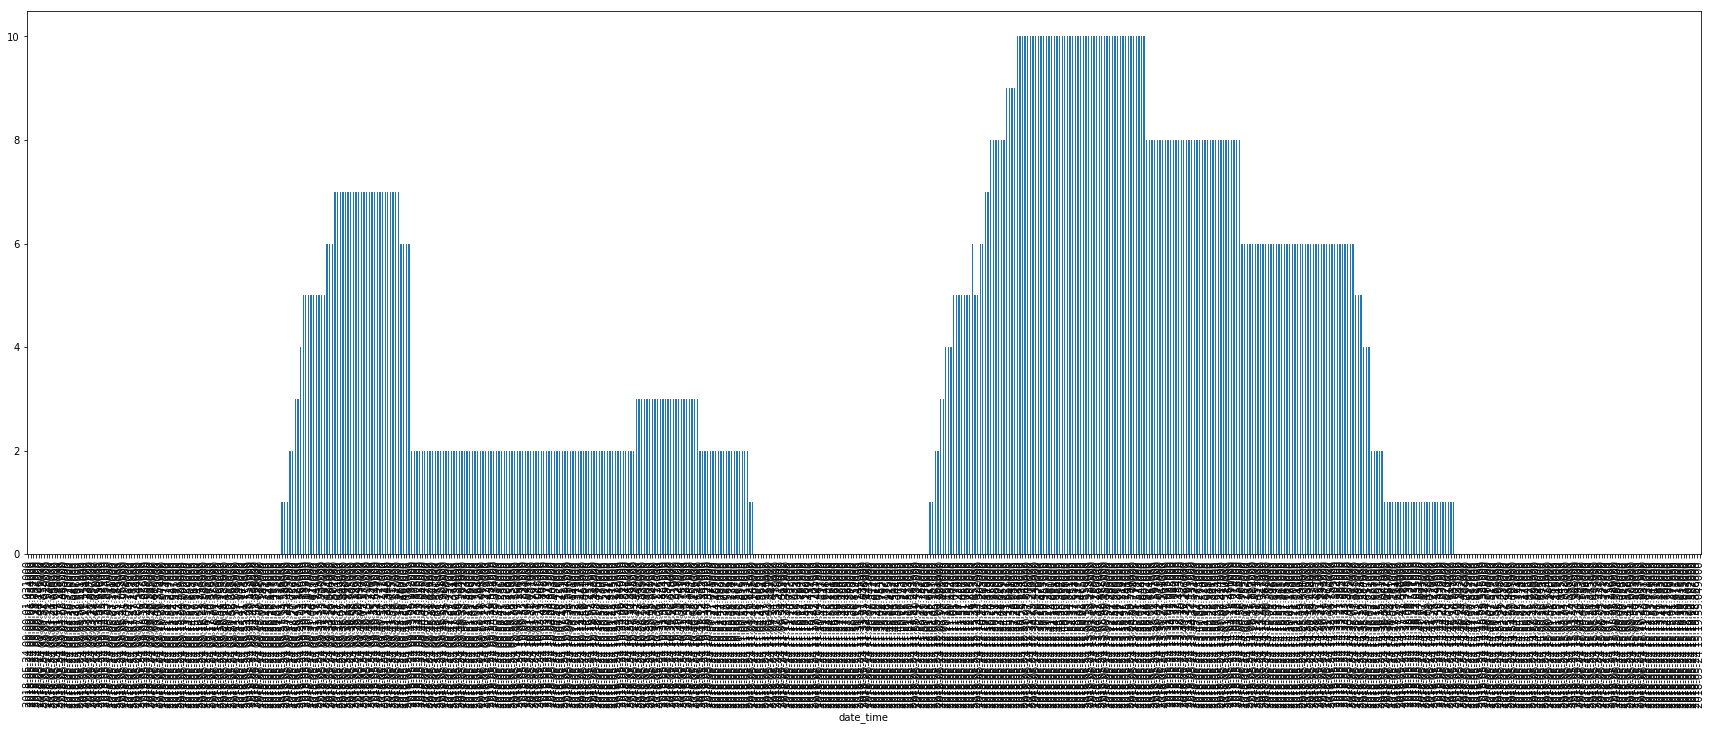

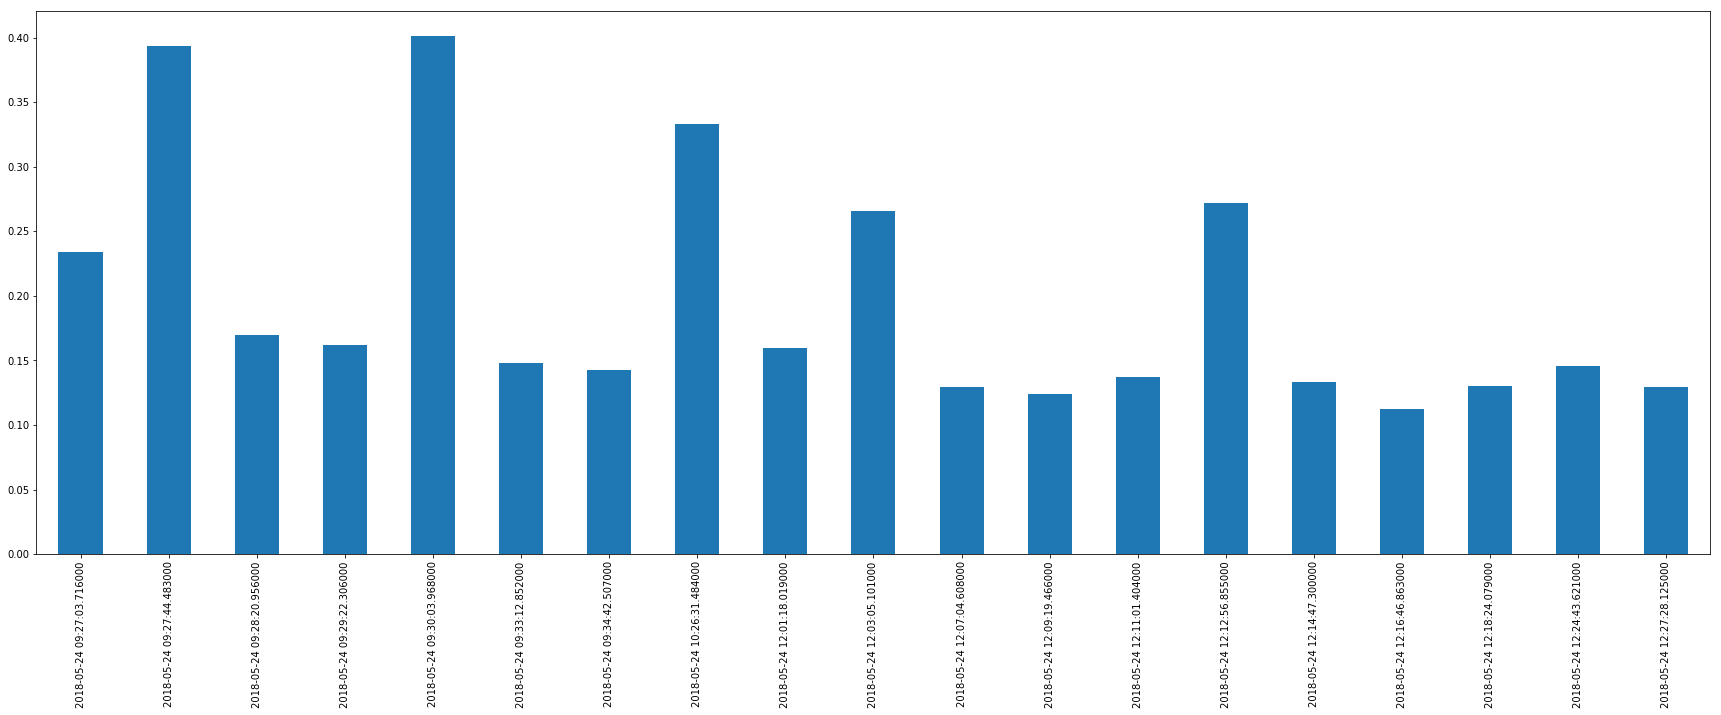

In [18]:
plot_co_events('2018-05-24', df, triple_barrier_events, num_co_events, tw)

## 4.5 Sequential Bootstrap

In [19]:
def get_ind_matrix(bar_idx, t1):
    # Get indicator matrix
    ind_m = pd.DataFrame(0, index=bar_idx,
                         columns=range(t1.shape[0]))
    for  i, (t0_, t1_) in tqdm(enumerate(t1.iteritems()), desc='get_ind_matrix'):
        ind_m.loc[t0_:t1_, i] = 1
    return ind_m


def get_avg_uniq(ind_m, c=None):
    if c is None:
        c = ind_m.sum(axis=1)
    ind_m = ind_m.loc[c > 0]
    c = c.loc[c > 0]
    u = ind_m.div(c, axis=0)
    avg_u = u[u > 0].mean()
    avg_u = avg_u.fillna(0)
    return avg_u

In [ ]:
def seqBootstrap(indM,sLength=None):
    # Generate a sample via sequential bootstrap 
    if sLength is None:
        sLength=indM.shape[1]
    phi=[] 
    #while len(phi) < sLength:
    for _ in tqdm(range(sLength), desc='seq bootstrap'):
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]]  # reduce indM
            avgU.loc[i]=get_avg_uniq(indM_).iloc[-1]
        prob=avgU/avgU.sum()  # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

In [ ]:
t1 = triple_barrier_events['t1']
beg_date = vbar.index[0]
end_date = vbar.index[-1]
seq = []
while beg_date < end_date:
    end_date_t1 = beg_date + datetime.timedelta(days=1)
    end_date_idx = beg_date + datetime.timedelta(days=2)
    if len(t1[beg_date:end_date_t1]) == 0:
        beg_date += datetime.timedelta(days=1)
        continue
    ind_m = get_ind_matrix(vbar[beg_date:end_date_idx].index, t1[beg_date:end_date_t1])
    seq += seqBootstrap(ind_m)
    print(ind_m.shape, len(seq))
    beg_date += datetime.timedelta(days=1)

get_ind_matrix: 81it [00:00, 141.18it/s]
seq bootstrap: 100%|██████████| 81/81 [03:33<00:00,  3.84s/it]
get_ind_matrix: 14it [00:00, 130.60it/s]

(3661, 81) 81


get_ind_matrix: 143it [00:01, 129.08it/s]
seq bootstrap: 100%|██████████| 143/143 [14:19<00:00, 10.45s/it]
get_ind_matrix: 36it [00:00, 883.66it/s]
seq bootstrap:   0%|          | 0/36 [00:00<?, ?it/s]

(2912, 143) 224


seq bootstrap: 100%|██████████| 36/36 [00:19<00:00,  1.25it/s]
get_ind_matrix: 22it [00:00, 687.68it/s]
seq bootstrap:   0%|          | 0/22 [00:00<?, ?it/s]

(1113, 36) 260


seq bootstrap: 100%|██████████| 22/22 [00:06<00:00,  2.68it/s]
get_ind_matrix: 15it [00:00, 145.89it/s]

(2722, 22) 282


get_ind_matrix: 80it [00:00, 149.82it/s]
seq bootstrap: 100%|██████████| 80/80 [02:53<00:00,  3.64s/it]
get_ind_matrix: 8it [00:00, 73.37it/s]

(4065, 80) 362


get_ind_matrix: 183it [00:02, 80.05it/s]
seq bootstrap: 100%|██████████| 183/183 [28:37<00:00, 17.24s/it]
get_ind_matrix: 8it [00:00, 79.21it/s]

(3606, 183) 545


get_ind_matrix: 150it [00:01, 81.35it/s]
seq bootstrap: 100%|██████████| 150/150 [18:59<00:00, 14.32s/it]
get_ind_matrix: 6it [00:00, 51.73it/s]

(4182, 150) 695


get_ind_matrix: 178it [00:03, 48.75it/s]
seq bootstrap: 100%|██████████| 178/178 [31:39<00:00, 17.05s/it]
get_ind_matrix: 6it [00:00, 51.09it/s]

(5110, 178) 873


get_ind_matrix: 422it [00:08, 50.26it/s]
seq bootstrap:  80%|███████▉  | 337/422 [3:42:58<1:40:09, 70.70s/it]

## MonteCarlo

In [ ]:
def getRndT1(numObs, numBars, maxH):
    # random t1 Series 
    t1=pd.Series()
    for i in range(numObs):
        ix = np.random.randint(0, numBars)
        val = ix + np.random.randint(1, maxH)
        t1.loc[ix] = val
    return t1.sort_index()

In [ ]:
def simpleBootstrap(indM, sLength=None):
    # Generate a sample via bootstrap
    if sLength is None:
        sLength = indM.shape[1]
        
    phi=[] 
    avgU = get_avg_uniq(indM)
    prob = avgU/avgU.sum()  # draw prob
    while len(phi) < sLength:
        phi += [np.random.choice(indM.columns, p=prob)]
    return phi

In [ ]:
def auxMC(numObs, numBars, maxH):
    # Parallelized auxiliary function
    t1 = getRndT1(numObs, numBars, maxH)
    barIx = range(t1.max()+1)
    indM = get_ind_matrix(barIx, t1)
    phi = np.random.choice(indM.columns, size=indM.shape[1])
    stdU = get_avg_uniq(indM[phi]).mean()
    phi = simpleBootstrap(indM)
    simU = get_avg_uniq(indM[phi]).mean()
    phi = seqBootstrap(indM)
    seqU = get_avg_uniq(indM[phi]).mean()
    return {'stdU':stdU, 'simU':simU, 'seqU':seqU}

In [ ]:
for _ in range(10):
    numObs = np.random.randint(50,200)
    numBars = np.random.randint(200,1000)
    maxH = np.random.randint(5,20)
    res = auxMC(numObs, numBars, maxH)
    print(res)

## 4.6 Return Attribution (Sample Weight)

In [ ]:
from finance_ml.sampling import time_weight
wgt = time_weight.get_sample_weight(np.log(vbar['close']).diff(), triple_barrier_events['t1'], num_co_events)

In [ ]:
print(wgt.shape)
print(wgt.head())

### - sample weight might handle as sklearn fit parameter

## Time Decay

In [ ]:
from finance_ml.sampling import weight
td = weight.get_time_decay(tw, last_w=0)
plt.plot(td)

In [ ]:
td = weight.get_time_decay(tw, last_w=0.1, is_exp=True)
plt.plot(td)